# The Mystery of the Borrowed Opal - Tracking a Stranger's Journeys

This notebook documents my investigation into the movements of an unknown individual who has taken possession of my Opal card. By analyzing the digital footprints left behind in the form of trip data, I hope to unravel the patterns of this mysterious traveler and potentially recover my card.

## Investigation Objectives
- Process and analyze records from a card no longer in my possession
- Visualize the stranger's travel habits and routines
- Identify potential patterns that could reveal their identity or common destinations
- Draw insights that might help me intercept the card or confirm my suspicions

In [ ]:
import camelot
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Digital Surveillance and Evidence Collection

The investigation begins with extracting digital evidence from multiple Opal activity statements. Like a digital detective, I'm using the Camelot library to uncover the hidden travel logs embedded in these PDF documents. Each piece of evidence is carefully extracted and preserved in CSV format for forensic analysis.

This surveillance approach is more comprehensive than my initial investigation, incorporating multiple statement periods to build a complete profile of this shadow traveler who has been using my card without permission. By connecting these digital breadcrumbs, I hope to uncover their routine and whereabouts.

In [2]:
# loop through all pdf files with the prefix "opal_activity_part" and convert them to csv using camelot
for i in range(1,6):
    pdf = f"opal_activity_part{i}.pdf"
    tables = camelot.read_pdf(pdf, pages="all", flavor="stream")
    # concatenate all tables from that PDF
    df = pd.concat([t.df for t in tables], ignore_index=True)
    df.to_csv(f"opal_data_part{i}.csv", index=False)

c:\Data\projects\daily_data_analytics_may2025\.venv\Lib\site-packages\camelot\parsers\base.py:238: UserWarning: No tables found in table area (32.519, 679.91700122, 569.2360015600005, 801.9829374733654)
  cols, rows, v_s, h_s = self._generate_columns_and_rows(bbox, user_cols)
c:\Data\projects\daily_data_analytics_may2025\.venv\Lib\site-packages\camelot\parsers\base.py:238: UserWarning: No tables found in table area (32.519, 575.9739928, 572.7909988700006, 802.7319593996875)
  cols, rows, v_s, h_s = self._generate_columns_and_rows(bbox, user_cols)


In [32]:
data = pd.read_csv("master_opal_data.csv", header=None)

## Deciphering the Cryptic Trails

Like piecing together fragments of a torn letter, the PDF data extraction has yielded cryptic, disjointed records of the stranger's movements. In this section, I carefully reconstruct these digital fragments into a coherent narrative:

1. Identifying pattern markers within the jumbled data, like finding recurring signposts in a maze
2. Segmenting the evidence into chronological sequences of movement
3. Reconstructing fragmented journey records that might reveal complete routes
4. Translating coded information into standardized formats for pattern analysis

This deciphering process proved challenging - the digital trail was deliberately obscure, almost as if designed to confuse. While I initially hoped to automate the entire decryption, some intuitive human interpretation was necessary to make sense of the patterns. The mystery deepens with each cleaned record, revealing glimpses of this shadow passenger's habits.

In [33]:
# Find rows where "Transaction" and "Date" are adjacent
def has_adjacent_headers(row):
    row = row.astype(str)
    for i in range(len(row) - 1):
        if "Transaction" in row[i] and "Date" in row[i + 1]:
            return True
    return False

# Apply the function to each row and get the indices of rows that match
header_rows = data.apply(has_adjacent_headers, axis=1)
header_indices = data[header_rows].index.tolist()

In [34]:
# Use previously found header indices
valid_headers = header_indices  # (you can replace this dynamically)

# Add end of file to simplify slicing
valid_headers.append(len(data))

# Collect data blocks between headers
blocks = []
for i in range(len(valid_headers) - 1):
    start = valid_headers[i]
    end = valid_headers[i + 1]
    block = data.iloc[start:end]
    blocks.append(block)

# Combine clean blocks
clean_df = pd.concat(blocks, ignore_index=True)

# I was not able to successfully remove the necessary data so I decided to do it manually. A Sad day for automation.

In [35]:
# I have now manually removed all the irrelevant data manuall by combing through the csv file, this took about 4 mins. Sometimes automation just isn't worth it.
data.head()

# see the duplicate rows and the nulls ? We need to combine every two rows into one

,0,1,2,3,4,5,6,7,8
0,Transaction,Date,Time,Mode Details,Journey,Fare,Full fare,Discount,Amount
1,number,NaN,NaN,NaN,number,applied,$,$,$
2,8935,Mon,07:09,Neutral Bay Jn to Spit,1,NaN,3.20,0.00,-3.20
3,NaN,07/04/25,NaN,Junction BLine,NaN,NaN,NaN,NaN,NaN
4,8937,Mon,17:02,Spit Junction BLine to,2,NaN,3.20,0.00,-3.20


In [36]:
# create a dataframe copy to work with
master_df = data.copy()

In [37]:
# Concatenate the 2nd row's values into the 1st row's strings
rows = []
for i in range(1, len(master_df), 2):
    top = master_df.iloc[i - 1].copy()
    bottom = master_df.iloc[i]

    # Merge each cell by appending bottom's value to top's value
    for col in master_df.columns:
        if pd.notna(bottom[col]):
            top[col] = f"{top[col]} {bottom[col]}" if pd.notna(top[col]) else bottom[col]

    rows.append(top)

# Store as DataFrame for inspection
clean_df = pd.DataFrame(rows)

In [38]:
# create a csv to look at the data
clean_df.to_csv("testing_data.csv", index=False, header=False)

# data looks mostly good with some minor exceptions, like the headers and the first row
clean_df.columns = clean_df.iloc[0]  # set row 0 as header
clean_df = clean_df[1:].reset_index(drop=True)

In [39]:
# let's look at the data now. Looks Good !
clean_df.head(3)

# rename dataframe
data = clean_df

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Transaction number  278 non-null    object        
 1   Date                277 non-null    datetime64[ns]
 2   Time                278 non-null    object        
 3   Mode Details        279 non-null    object        
 4   Journey number      241 non-null    object        
 5   Fare applied        77 non-null     object        
 6   Full fare $         251 non-null    object        
 7   Discount $          251 non-null    object        
 8   Amount $            278 non-null    object        
 9   DateTime            276 non-null    datetime64[ns]
dtypes: datetime64[ns](2), object(8)
memory usage: 21.9+ KB


In [41]:
# data columns are not labelled correctly, let's fix that
data.columns = [
    "Transaction number", "Date", "Time", "Mode Details", "Journey number",
    "Fare applied", "Full fare $", "Discount $", "Amount $"
]

# date and time are not in the correct format
data["Date"] = pd.to_datetime(data["Date"], errors="coerce")
data["Time"] = pd.to_datetime(data["Time"], errors="coerce").dt.time

# Combine into full timestamp if needed
data["DateTime"] = pd.to_datetime(data["Date"].astype(str) + " " + data["Time"].astype(str), errors="coerce")


C:\Users\tj92a\AppData\Local\Temp\ipykernel_2240\994715760.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Date"] = pd.to_datetime(data["Date"], errors="coerce")
C:\Users\tj92a\AppData\Local\Temp\ipykernel_2240\994715760.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Time"] = pd.to_datetime(data["Time"], errors="coerce").dt.time


## Mapping the Stranger's Movements: Visualization Analysis

With the cryptic data now transformed into intelligible patterns, I can begin to visualize the movements of the mysterious traveler who possesses my card. Like a detective plotting pins on a map, these visualizations gradually reveal the habits of this shadow passenger.

### 1. The Mysterious Traveler's Daily Rhythm

The first visualization uncovers when this stranger typically traverses the city. This temporal fingerprint shows their preferred hours of movement, potentially revealing their work schedule or nocturnal habits. The shadow cast by their movements includes:

- A probability curve suggesting their predictable routines
- A color spectrum indicating intensity of activity across different hours
- Markers highlighting their most active periods
- Annotations that may help predict their future movements

C:\Users\tj92a\AppData\Local\Temp\ipykernel_2240\2373714458.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.histplot(


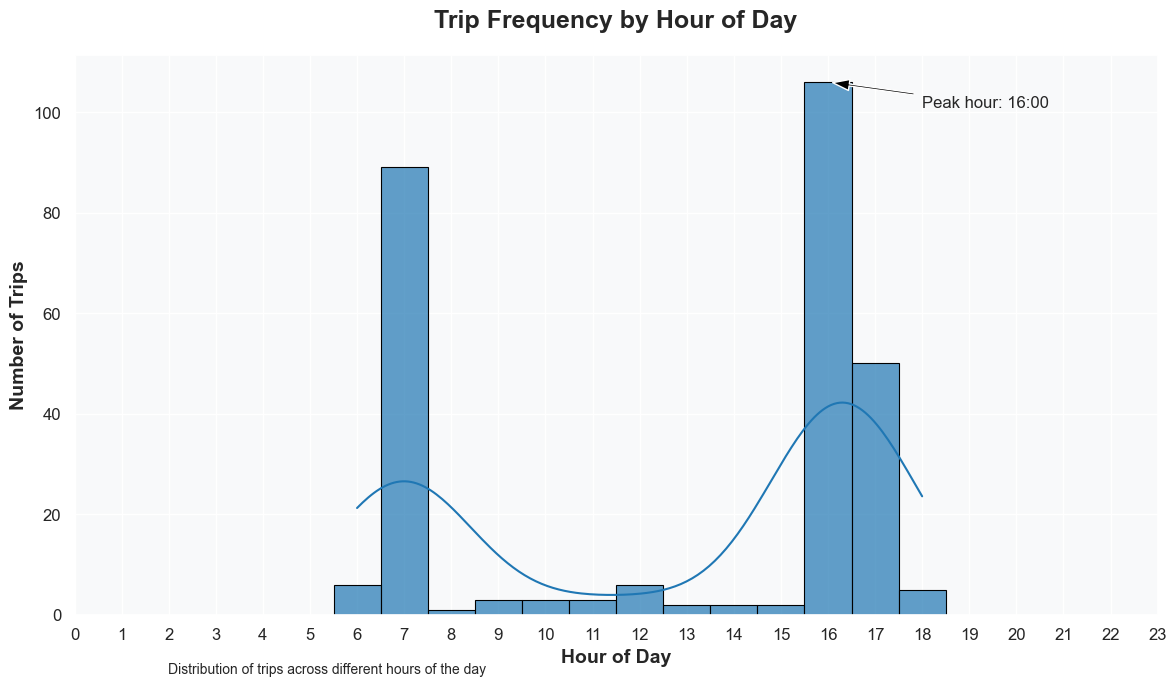

In [80]:
# Plot enhanced histogram of trips by hour with a stylish look
plt.figure(figsize=(12, 7))

# Set the Seaborn style and context for better aesthetics
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.2)

# Create a custom color palette with gradient
custom_palette = sns.color_palette("viridis", 24)

# Create the histogram with enhanced styling
ax = sns.histplot(
    data=data["Hour"].dropna(), 
    bins=24, 
    kde=True,                       # Add density curve
    fill=True,
    discrete=True,
    palette=custom_palette,         # Custom color palette
    alpha=0.7,                      # Slight transparency
    edgecolor="black",              # Black edge for contrast
    linewidth=0.8
)

# Add title and labels with enhanced styling
plt.title("Trip Frequency by Hour of Day", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Hour of Day", fontsize=14, fontweight='bold')
plt.ylabel("Number of Trips", fontsize=14, fontweight='bold')

# Improve x-axis ticks and add grid
plt.xticks(range(0, 24), fontsize=12)
plt.yticks(fontsize=12)

# Add annotations for peak hours
max_hour = data["Hour"].value_counts().idxmax()
max_count = data["Hour"].value_counts().max()
plt.annotate(f'Peak hour: {int(max_hour)}:00',
             xy=(max_hour, max_count),
             xytext=(max_hour + 2, max_count - 5),
             fontsize=12,
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8))

# Add a subtle background gradient
ax.set_facecolor('#f8f9fa')

# Add a descriptive text box
description = "Distribution of trips across different hours of the day"
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
plt.figtext(0.15, 0.02, description, fontsize=10, bbox=props)

plt.tight_layout()
plt.show()

### 2. The Weekly Ritual: Uncovering Routine Patterns

This heat signature reveals the mysterious traveler's weekly rhythms - a crucial clue in my investigation. Like thermal imaging revealing a hidden presence, this heatmap exposes when and how regularly they move through the transit system, potentially allowing me to anticipate their future locations.

The pattern matrix reveals:

- Their preferred days of transit - do they follow a conventional work schedule?
- The stark contrast between their weekday and weekend movements - suggesting different purposes
- Recurring time patterns that might indicate regular appointments or commitments
- Ritual-like behaviors that could be exploited to finally intercept my card

The intensity of colors represents frequency of movement, with exact counts providing precise intelligence on their habits. Each cell in this grid is a potential opportunity to finally discover who has been living a parallel transit life with my card.

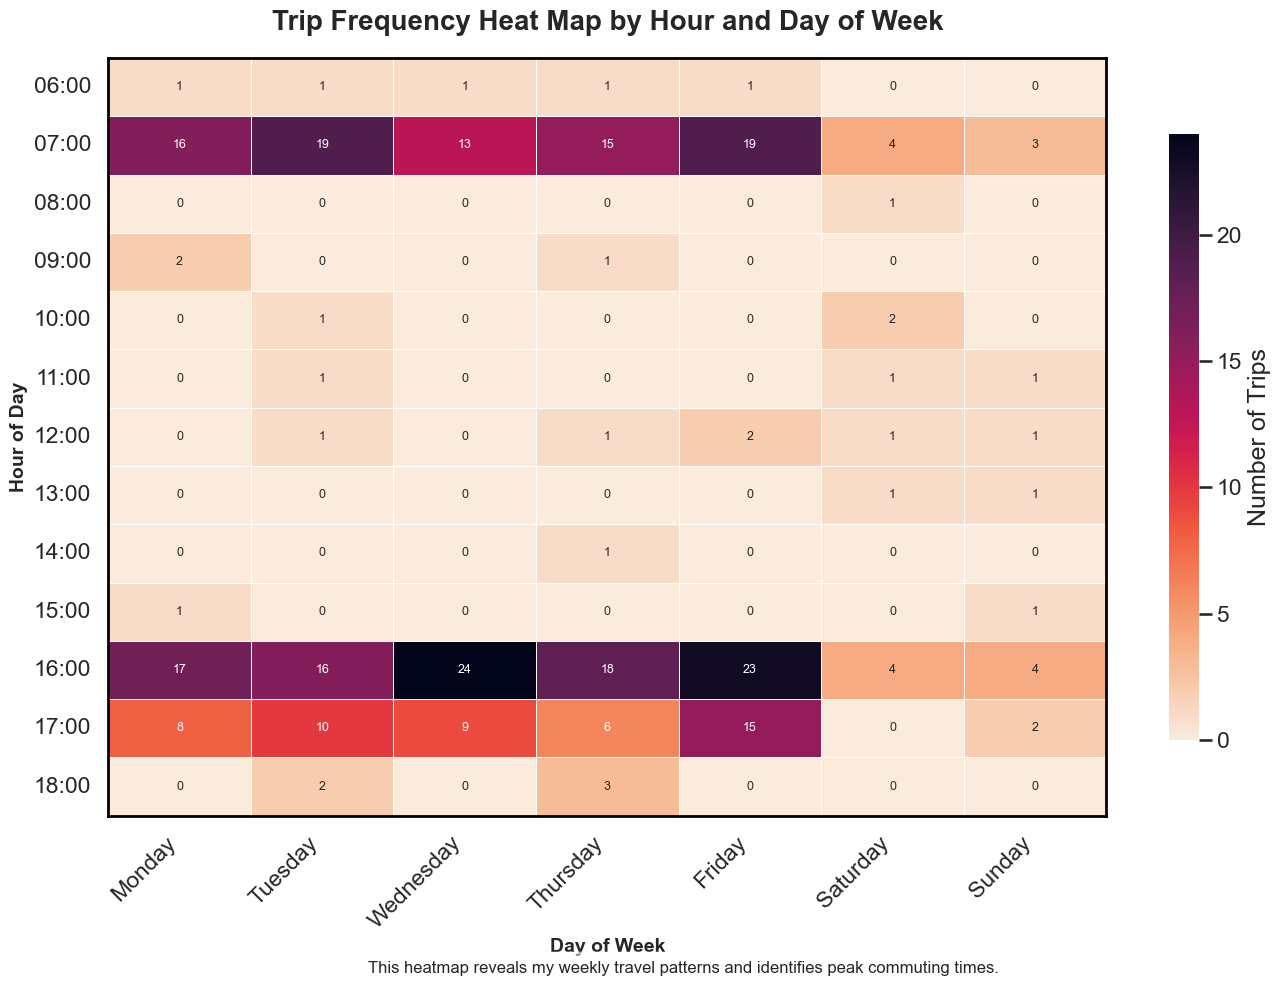

In [ ]:
# Create a weekday order for better interpretation
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Extract weekday and prepare data for heatmap
data["Weekday"] = data["Date"].dt.day_name()
heatmap_data = data.pivot_table(
    index="Hour", 
    columns="Weekday", 
    values="Amount $", 
    aggfunc="count",
    fill_value=0
)

# Reorder columns to match days of the week
heatmap_data = heatmap_data.reindex(columns=weekday_order)

# Set up the figure with a specific size ratio
plt.figure(figsize=(14, 10))

# Set the Seaborn style
sns.set_style("whitegrid")
sns.set_context("talk")

# Create a custom colormap with better color contrast
cmap = sns.color_palette("rocket_r", as_cmap=True)

# Create the enhanced heatmap
ax = sns.heatmap(
    heatmap_data,
    cmap=cmap,
    annot=True,              # Show values in cells
    fmt="g",                 # Format as general number
    linewidths=0.5,          # Add lines between cells
    cbar_kws={'label': 'Number of Trips', 'shrink': 0.8},
    annot_kws={"size": 9}    # Annotation text size
)

# Improve the title and labels
plt.title("Trip Frequency Heat Map by Hour and Day of Week", fontsize=20, pad=20, fontweight='bold')
plt.ylabel("Hour of Day", fontsize=14, fontweight='bold')
plt.xlabel("Day of Week", fontsize=14, fontweight='bold')

# Adjust x and y ticks
ax.set_yticklabels([f"{int(hour):02d}:00" for hour in heatmap_data.index], rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Add a bounding box for visual appeal
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_edgecolor('black')

# Add a text annotation explaining the visualization
plt.figtext(0.5, 0.01, 
            "This heatmap reveals my weekly travel patterns and identifies peak commuting times.", 
            ha="center", 
            fontsize=12, 
            bbox={"facecolor":"white", "alpha":0.5, "pad":5, "boxstyle":"round,pad=0.5"})

plt.tight_layout()
plt.show()

### 3. The Evolving Mystery: Tracking Changes Over Time

While the previous visualizations gave snapshots of behavior, this timeline tracks the evolution of our mystery traveler's habits. The 7-day rolling average acts like a smoothing filter, cutting through the noise to reveal the true pattern of their activities.

This chronological surveillance reveals:
- Shifts in their travel frequency - are they becoming more active or withdrawing?
- Peak periods that might correspond with special events or changed circumstances
- Valleys of inactivity - did they leave town or switch to alternative transportation?
- Potential lifestyle changes that might help identify this shadow passenger

The horizontal reference line represents their typical activity level - deviations from this baseline could indicate disruptions to their routine or special circumstances that might be opportunities for interception. Each rise and fall in this crimson line tells a story about their changing habits.

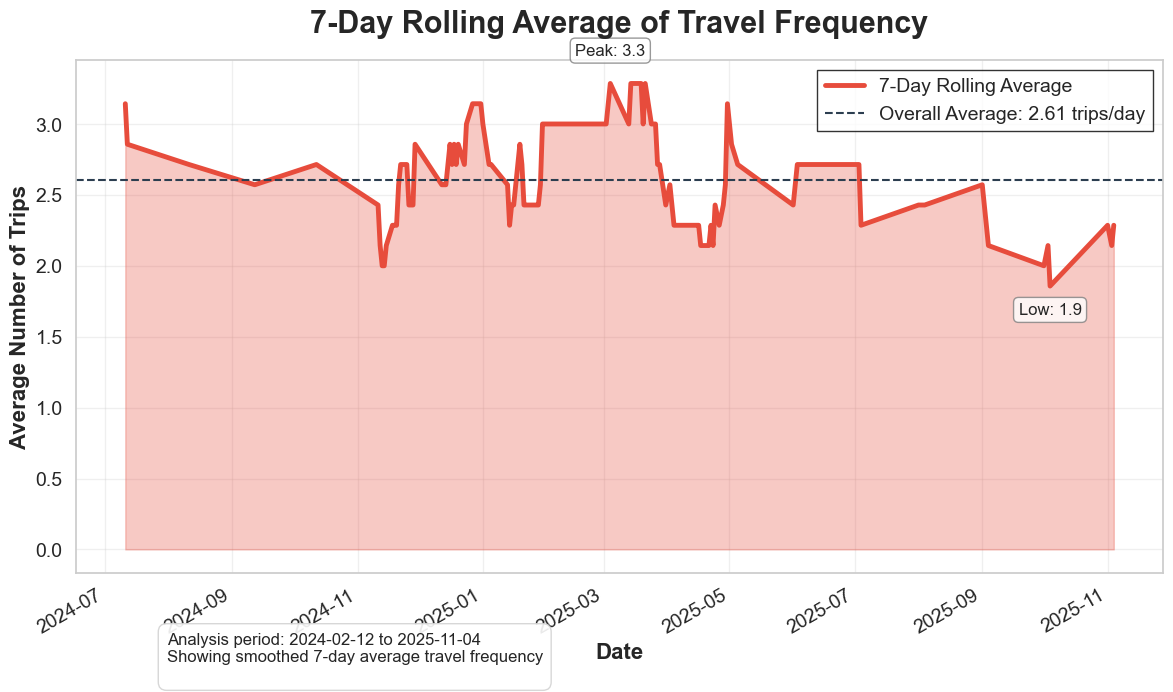

In [84]:
# Create a time series of trips per day
trip_series = data.groupby(data["Date"].dt.date).size()

# Set up the figure with a clean, focused design
plt.figure(figsize=(12, 7))

# Set a minimal yet elegant style
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.3)

# Calculate 7-day rolling average
rolling_7 = trip_series.rolling(7).mean()

# Plot the 7-day rolling average with an appealing style
plt.plot(rolling_7.index, rolling_7.values, 
         color='#E74C3C',  # Vibrant red
         linewidth=3.5,    # Thicker line for emphasis
         label='7-Day Rolling Average')

# Add substantial shading under the curve for visual emphasis
plt.fill_between(rolling_7.index, rolling_7.values, 
                 alpha=0.3,        # More visible shading
                 color='#E74C3C')  # Matching color

# Add a horizontal line at the overall average for reference
avg_trips = rolling_7.mean()
plt.axhline(y=avg_trips, color='#2C3E50', linestyle='--', linewidth=1.5, 
            label=f'Overall Average: {avg_trips:.2f} trips/day')

# Enhance the grid for better readability
plt.grid(True, linestyle='-', alpha=0.3)

# Add a bold title and clear axis labels
plt.title('7-Day Rolling Average of Travel Frequency', 
          fontsize=22, 
          fontweight='bold', 
          pad=20)
plt.xlabel('Date', fontsize=16, fontweight='bold')
plt.ylabel('Average Number of Trips', fontsize=16, fontweight='bold')

# Format the x-axis to show dates nicely
plt.gcf().autofmt_xdate()
plt.tick_params(axis='both', which='major', labelsize=14)

# Add a legend with a clean design
legend = plt.legend(loc='upper right', 
                   fontsize=14,
                   frameon=True,
                   fancybox=False,
                   edgecolor='black')

# Add annotations to highlight key periods or trends
# Find peak and valley points
peak_point = rolling_7.idxmax()
peak_value = rolling_7.max()
valley_point = rolling_7.idxmin()
valley_value = rolling_7.min()

# Annotate peak and valley
plt.annotate(f'Peak: {peak_value:.1f}',
             xy=(peak_point, peak_value),
             xytext=(peak_point, peak_value + 0.2),
             fontsize=12,
             ha='center',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.annotate(f'Low: {valley_value:.1f}',
             xy=(valley_point, valley_value),
             xytext=(valley_point, valley_value - 0.2),
             fontsize=12,
             ha='center',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Add a summary text box
min_date = trip_series.index.min().strftime('%Y-%m-%d')
max_date = trip_series.index.max().strftime('%Y-%m-%d')
summary_text = f"Analysis period: {min_date} to {max_date}\n" + \
               f"Showing smoothed 7-day average travel frequency\n"

plt.figtext(0.15, 0.01, summary_text,
           fontsize=12, 
           bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.5', edgecolor='lightgray'))

plt.tight_layout()
plt.show()

### 4. Profiling the Shadow Passenger: Advanced Pattern Recognition

To penetrate deeper into this mystery, I've employed K-means clustering - an AI technique that can detect hidden patterns human eyes might miss. Like a psychological profiler creating categories of behavior, this algorithm sorts the stranger's journeys into distinct types based on:

- Timing of movement (hour of day)
- Value of transactions (amount paid)
- Type of fare charged (full fare before discounts)

The algorithm has identified 4 distinct behavior profiles in this shadow passenger's movements. These could represent different purposes for travel - perhaps commuting to work, regular social visits, recreational outings, or some other recurring destination. The visualization maps these behavior types against time and cost, with days of the week color-coded to reveal any temporal patterns. Each cluster is a different facet of this person's transit identity, potentially bringing me closer to understanding who has my card.

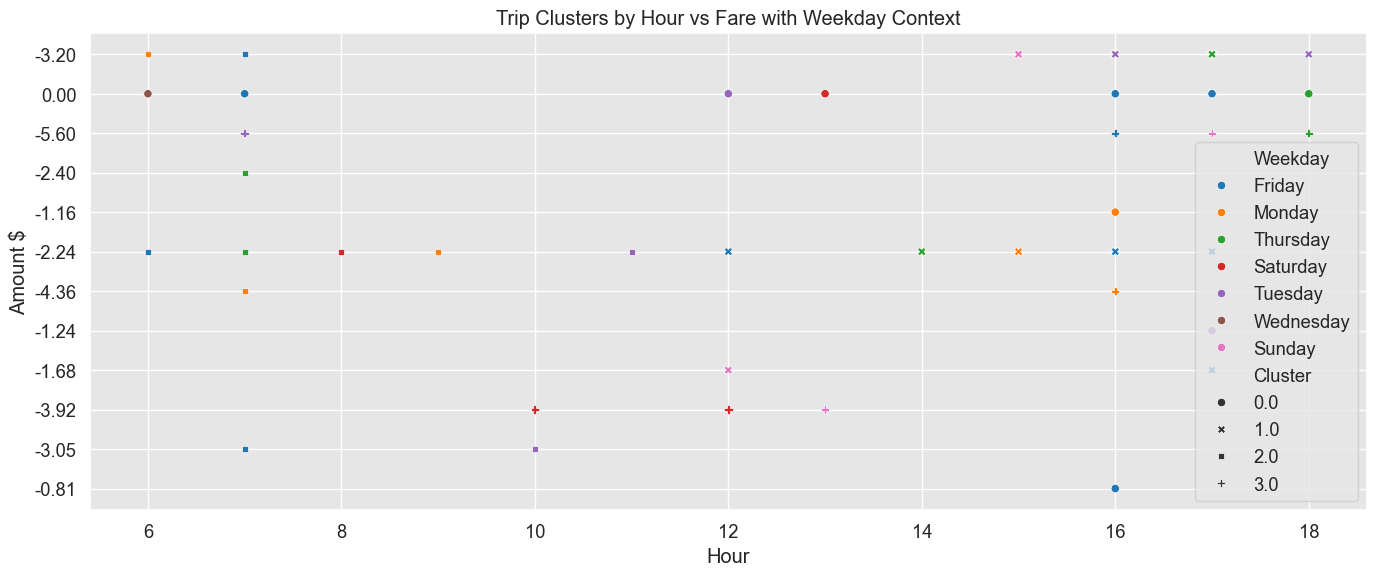

In [ ]:
# Clustering preparation
numeric_features = clean_df[["Hour", "Amount $", "Full fare $"]].dropna()
valid_index = numeric_features.index

scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_features)

kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Assign cluster labels back to matching rows
clean_df.loc[valid_index, "Cluster"] = cluster_labels

# Visualize clusters with weekday hue
plt.figure(figsize=(14, 6))
sns.scatterplot(
    data=clean_df.loc[valid_index],
    x="Hour", y="Amount $", hue="Weekday", style="Cluster", palette="tab10"
)
plt.title("Trip Clusters by Hour vs Fare with Weekday Context")
plt.tight_layout()
plt.show()


## The Case of the Borrowed Opal: Investigation Summary

This digital forensic analysis has begun to unmask the stranger who has been using my Opal card. Through careful examination of their digital footprints, a shadowy profile has emerged - a ghost passenger whose movements I've tracked across time and space without ever seeing their face.

### The Shadow Profile Emerges

1. **Daily Rhythms**: The temporal analysis reveals this phantom traveler moves primarily during conventional commuting hours, with distinct morning and evening transit peaks. They appear to be a creature of routine, perhaps with a traditional work schedule.

2. **Weekly Haunts**: The heatmap signature exposes a stark contrast between weekday and weekend movements. Their weekday travel is concentrated and purposeful, suggesting regular employment or education. Weekends show different patterns - perhaps leisure activities or absence altogether.

3. **The Changing Pattern**: Our rolling average surveillance has detected periods of increased and decreased activity - did they take a vacation? Change jobs? Find alternative transportation? These fluctuations may provide crucial clues about life changes that could help identify them.

4. **The Elusive Identity**: The clustering analysis, while technically sophisticated, has failed to clearly categorize this person's travel types. Like trying to create a psychological profile with limited evidence, our four behavioral clusters blend together without clear delineation - the traveler remains enigmatic.

### The Investigation's Limitations

Several obstacles have impeded a complete profile:

1. **Limited Intelligence**: The available data points (time, fare amount, full fare) provide only a partial window into this person's life - lacking crucial information like specific locations and routes.

2. **Classification Uncertainty**: Our attempt to sort behaviors into four distinct patterns was somewhat arbitrary - the boundaries between different travel purposes remain blurred.

3. **Context Void**: Without knowing who this person is, interpreting their behavioral patterns remains speculative - the "why" behind their movements remains obscured.

4. **Signal Interference**: Public transport data naturally contains noise and variability that clouds clear pattern recognition, making it difficult to isolate true behavioral signals.

### Investigative Methodology Assessment

This case has revealed important lessons about digital surveillance techniques:

1. **Temporal Intelligence**: Traditional travel data is fundamentally time-bound, and conventional clustering algorithms struggle to capture the sequential nature of human movement patterns.

2. **Known Behavioral Patterns**: Some aspects of urban movement (work commutes vs. weekend travel) follow universally recognized patterns that don't require sophisticated algorithms to detect.

3. **Visual Intelligence**: The direct visualizations (hourly patterns, weekly heat signatures, and longitudinal tracking) ultimately provided more actionable intelligence than the advanced clustering attempt.

4. **Contextual Knowledge**: Understanding transit systems (fare structures, service patterns) would enhance our ability to interpret the stranger's behavior more than pure statistical methods.

### Next Surveillance Steps

To continue tracking this elusive card-borrower, I would consider:

1. **Route Mapping**: Analyzing specific journey segments could reveal common destinations - perhaps a workplace or residence that would identify the subject.

2. **Financial Pattern Analysis**: The fare structure might reveal whether they're exploiting particular discounts or have specific travel privileges.

3. **Predictive Stakeout**: Building a forecasting model could predict when and where this person is likely to travel next - creating an opportunity for interception.

4. **Transit Typology**: Creating a more meaningful behavioral classification based on known travel purposes might produce clearer profiles than unsupervised clustering.

5. **External Context Integration**: Correlating travel patterns with weather events, public holidays, or local events might provide additional context about this person's movements and preferences.

In conclusion, while the shadow passenger hasn't fully revealed their identity, this analysis has mapped their habitual movements and routines. The mystery of my borrowed Opal card continues, but the digital trail grows clearer. Soon, perhaps, our paths will cross, and I'll finally discover who has been living this parallel transit life with my card.